### Count regression

This notebook demonstrates the use of TFP for regression on count data. The dataset is the number of fish caught in a state park. 

* Poisson Regression
* Zero Infated Poisson Regression



In [ ]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Creating some count data

This is just to demonstrate how to use TF distributions for a Poisson distribution, with given parameters. Below we learn the paramters. 

2.0
1.4142135


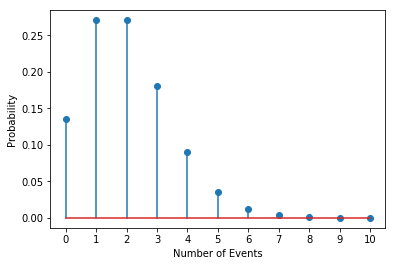

In [3]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E
plt.xticks(vals)
plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.savefig('ch05_rain.pdf')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

## Loading some count data

We use some traditional count data from: https://stats.idre.ucla.edu/r/dae/zip/. The number fish caught during a state park visit.

In [4]:
# Alternative version
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/nb_data.csv') 
# X = dat[...,0:3]
# y = dat[...,4]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [19]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
#dat = np.loadtxt('../data/fish.csv', delimiter=',', skiprows=1)
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = np.sqrt(dat[...,7])
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=1)
d = X_tr.shape[1]
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape

((167, 4), (167,), (83, 4), (83,), (250, 8))

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
model = LinearRegression()
res = model.fit(X_tr, y_tr)
y_t = model.predict(X_tr)
np.sqrt(np.mean((y_t - y_tr)**2)),np.mean((y_t - y_tr)**2)
res.intercept_,res.coef_

(-1.194179359853515,
 array([ 0.57213991,  0.47855112,  0.81969841, -1.09167139]))

6.164414002968976

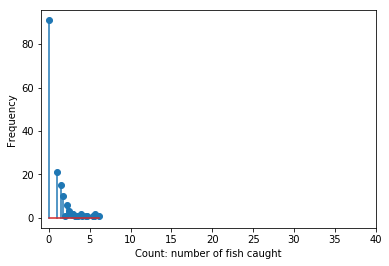

In [22]:
vals, counts = np.unique(y_tr, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.savefig('ch05_school.pdf')
np.max(y_tr)

## 1 Doing linear regression

In this section we do a standard linear regression.

In [23]:
model_lr = tf.keras.Sequential() #A
model_lr.add(tf.keras.layers.Dense(1,input_dim=d, activation='linear')) #B 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.001))

In [24]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=1200, verbose=False, batch_size=len(y_tr));
#hist_lr = model_lr.fit(x=X_tr, y=np.sqrt(y_tr), validation_data=(X_te, y_te), epochs=600, verbose=False);

1.4321416492263477

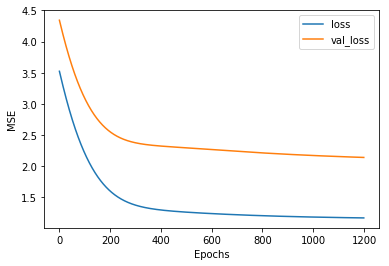

In [25]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [26]:
model_lr.get_weights()

[array([[ 0.2070897 ],
        [ 0.16893148],
        [ 0.6659379 ],
        [-0.9786964 ]], dtype=float32), array([-0.33521238], dtype=float32)]

In [27]:
res.intercept_,res.coef_

(-1.194179359853515,
 array([ 0.57213991,  0.47855112,  0.81969841, -1.09167139]))

In [28]:
y_hat_tr = model_lr.predict(X_tr)
y_t = model.predict(X_tr)

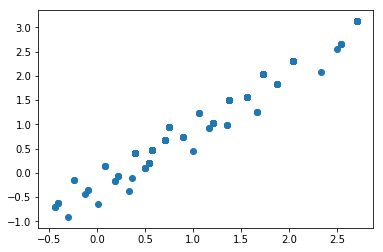

In [29]:
plt.scatter(y_hat_tr, y_t)

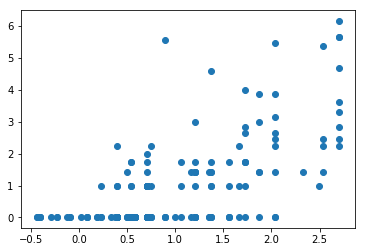

In [30]:
plt.scatter(y_hat_tr, y_tr)

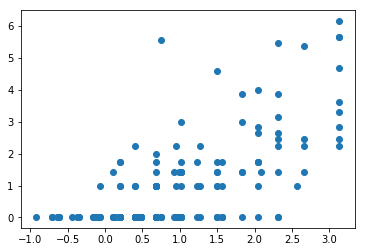

In [31]:
plt.scatter(y_t, y_tr)

In [32]:
y_hat_te = model_lr.predict(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te)) #(8.540011535073502, 6.001939873018208)
#np.sqrt(np.mean((y_hat_te**2 - y_te)**2)),np.mean(np.abs(y_hat_te**2 - y_te)) #(8.540011535073502, 6.001939873018208)

(1.9167475680236996, 1.157702617038657)

Text(0, 0.5, 'Predicted ')

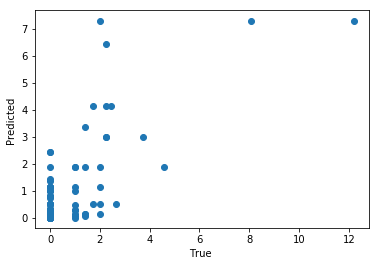

In [33]:
plt.scatter(y_te, y_hat_te**2)
plt.xlabel('True ')
plt.ylabel('Predicted ')

### Estimating the likelihood in LR (reestimating $\sigma$)

In linear regression, we assuming that the $\sigma$ is constant. To calculate the absolute NLL, we need to estimate this quantity from the training data. 

In [34]:
y_hat_tr = model_lr.predict(X_tr) #Trainingset
sigma_hat_2 = np.var(y_hat_tr.flatten() - y_tr)
NLL_n =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2
NLL_n,sigma_hat_2

(2.5682615784009, 1.169159524380048)

### Maximum likelihood LR also estimating the variance

In [35]:
sig = tf.Variable(5.66, dtype='float32')

def gauss(out): 
    return tfd.Normal(loc=out, scale=sig)
 
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
mu = tf.keras.layers.Dense(1)(inputs)
#out = tf.concat([mu, sig],axis=-1)
p_y = tfp.layers.DistributionLambda(gauss)(mu) 
model_lr = Model(inputs=inputs, outputs=p_y) 


def negloglik(y_true, y_hat): 
  return -tf.reduce_mean(y_hat.log_prob(y_true))

model_lr.compile(tf.optimizers.Adam(learning_rate=0.01),loss=negloglik) 

In [36]:
model_lr.trainable_weights    

[<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 0.5288104 ],
        [ 0.28163075],
        [-1.0573573 ],
        [-0.3436523 ]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [37]:
optimizer=tf.optimizers.RMSprop()
loss_values = np.zeros((500))
for e in range(500):
    with tf.GradientTape() as tape:
        y_hat = model_lr(X_tr)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
        loss_values[e] = loss_value
        weights =  model_lr.trainable_weights
        weights.append(sig)
        grads = tape.gradient(loss_value, weights)              
        #weights =  model_lr.trainable_weights
        optimizer.apply_gradients(zip(grads,weights))
        if e % 100 == 0:
            print(loss_value, " ", sig)

tf.Tensor(2.8838384, shape=(), dtype=float32)   <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.6568375>
tf.Tensor(2.807916, shape=(), dtype=float32)   <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.5482597>
tf.Tensor(2.7459824, shape=(), dtype=float32)   <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.4469414>
tf.Tensor(2.6921997, shape=(), dtype=float32)   <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.3459353>
tf.Tensor(2.6475334, shape=(), dtype=float32)   <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.2451916>


In [38]:
model_lr.trainable_weights, sig

([<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
  array([[ 1.0205046 ],
         [ 0.7652056 ],
         [-0.5603665 ],
         [ 0.15271682]], dtype=float32)>,
  <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.49467352], dtype=float32)>],
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.145687>)

In [39]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=True);

Train on 167 samples, validate on 83 samples
Epoch 1/2000
167/167 [==============================] - 0s 491us/sample - loss: 2.6166 - val_loss: 2.6269
Epoch 2/2000
167/167 [==============================] - 0s 89us/sample - loss: 2.6121 - val_loss: 2.6264
Epoch 3/2000
167/167 [==============================] - 0s 70us/sample - loss: 2.6098 - val_loss: 2.6255
Epoch 4/2000
167/167 [==============================] - 0s 83us/sample - loss: 2.6080 - val_loss: 2.6239
Epoch 5/2000
167/167 [==============================] - 0s 85us/sample - loss: 2.6064 - val_loss: 2.6224
Epoch 6/2000
167/167 [==============================] - 0s 112us/sample - loss: 2.6046 - val_loss: 2.6208
Epoch 7/2000
167/167 [==============================] - 0s 78us/sample - loss: 2.6032 - val_loss: 2.6193
Epoch 8/2000
167/167 [==============================] - 0s 91us/sample - loss: 2.6017 - val_loss: 2.6180
Epoch 9/2000
167/167 [==============================] - 0s 87us/sample - loss: 2.6005 - val_loss: 2.6168
Epoch 10

167/167 [==============================] - 0s 52us/sample - loss: 2.5782 - val_loss: 2.5952
Epoch 154/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5782 - val_loss: 2.5953
Epoch 155/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5782 - val_loss: 2.5954
Epoch 156/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5782 - val_loss: 2.5954
Epoch 157/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5783 - val_loss: 2.5951
Epoch 158/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5782 - val_loss: 2.5952
Epoch 159/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 160/2000
167/167 [==============================] - 0s 71us/sample - loss: 2.5782 - val_loss: 2.5950
Epoch 161/2000
167/167 [==============================] - 0s 52us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 162/2000
167/167 [============================

167/167 [==============================] - 0s 55us/sample - loss: 2.5782 - val_loss: 2.5942
Epoch 306/2000
167/167 [==============================] - 0s 52us/sample - loss: 2.5782 - val_loss: 2.5944
Epoch 307/2000
167/167 [==============================] - 0s 52us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 308/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 309/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 310/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 311/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 312/2000
167/167 [==============================] - 0s 50us/sample - loss: 2.5783 - val_loss: 2.5953
Epoch 313/2000
167/167 [==============================] - 0s 54us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 314/2000
167/167 [============================

167/167 [==============================] - 0s 54us/sample - loss: 2.5781 - val_loss: 2.5951
Epoch 458/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 459/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 460/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 461/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 462/2000
167/167 [==============================] - 0s 71us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 463/2000
167/167 [==============================] - 0s 81us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 464/2000
167/167 [==============================] - 0s 67us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 465/2000
167/167 [==============================] - 0s 73us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 466/2000
167/167 [============================

167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 610/2000
167/167 [==============================] - 0s 61us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 611/2000
167/167 [==============================] - 0s 48us/sample - loss: 2.5781 - val_loss: 2.5952
Epoch 612/2000
167/167 [==============================] - 0s 50us/sample - loss: 2.5782 - val_loss: 2.5952
Epoch 613/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 614/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 615/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 616/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5780 - val_loss: 2.5954
Epoch 617/2000
167/167 [==============================] - 0s 57us/sample - loss: 2.5783 - val_loss: 2.5958
Epoch 618/2000
167/167 [============================

167/167 [==============================] - 0s 57us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 686/2000
167/167 [==============================] - 0s 65us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 687/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5782 - val_loss: 2.5952
Epoch 688/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5782 - val_loss: 2.5945
Epoch 689/2000
167/167 [==============================] - ETA: 0s - loss: 2.572 - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5944
Epoch 690/2000
167/167 [==============================] - 0s 64us/sample - loss: 2.5782 - val_loss: 2.5945
Epoch 691/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 692/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 693/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 694/2000
167/167 [====

167/167 [==============================] - 0s 82us/sample - loss: 2.5782 - val_loss: 2.5943
Epoch 838/2000
167/167 [==============================] - 0s 69us/sample - loss: 2.5782 - val_loss: 2.5942
Epoch 839/2000
167/167 [==============================] - 0s 91us/sample - loss: 2.5782 - val_loss: 2.5943
Epoch 840/2000
167/167 [==============================] - 0s 78us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 841/2000
167/167 [==============================] - 0s 90us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 842/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 843/2000
167/167 [==============================] - 0s 72us/sample - loss: 2.5780 - val_loss: 2.5942
Epoch 844/2000
167/167 [==============================] - 0s 75us/sample - loss: 2.5782 - val_loss: 2.5942
Epoch 845/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5783 - val_loss: 2.5942
Epoch 846/2000
167/167 [============================

167/167 [==============================] - 0s 81us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 990/2000
167/167 [==============================] - 0s 57us/sample - loss: 2.5780 - val_loss: 2.5945
Epoch 991/2000
167/167 [==============================] - 0s 50us/sample - loss: 2.5782 - val_loss: 2.5944
Epoch 992/2000
167/167 [==============================] - 0s 74us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 993/2000
167/167 [==============================] - 0s 74us/sample - loss: 2.5780 - val_loss: 2.5950
Epoch 994/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5782 - val_loss: 2.5953
Epoch 995/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5782 - val_loss: 2.5950
Epoch 996/2000
167/167 [==============================] - 0s 66us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 997/2000
167/167 [==============================] - 0s 85us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 998/2000
167/167 [============================

Epoch 1065/2000
167/167 [==============================] - 0s 61us/sample - loss: 2.5781 - val_loss: 2.5943
Epoch 1066/2000
167/167 [==============================] - 0s 65us/sample - loss: 2.5781 - val_loss: 2.5943
Epoch 1067/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5944
Epoch 1068/2000
167/167 [==============================] - 0s 76us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1069/2000
167/167 [==============================] - 0s 76us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1070/2000
167/167 [==============================] - 0s 72us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1071/2000
167/167 [==============================] - 0s 81us/sample - loss: 2.5780 - val_loss: 2.5948
Epoch 1072/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1073/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1074/2000
167/167 [===

167/167 [==============================] - 0s 55us/sample - loss: 2.5785 - val_loss: 2.5954
Epoch 1217/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 1218/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 1219/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 1220/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5780 - val_loss: 2.5949
Epoch 1221/2000
167/167 [==============================] - 0s 64us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1222/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 1223/2000
167/167 [==============================] - 0s 69us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1224/2000
167/167 [==============================] - 0s 50us/sample - loss: 2.5782 - val_loss: 2.5943
Epoch 1225/2000
167/167 [===================

Epoch 1292/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1293/2000
167/167 [==============================] - 0s 66us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1294/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1295/2000
167/167 [==============================] - 0s 56us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1296/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5952
Epoch 1297/2000
167/167 [==============================] - 0s 64us/sample - loss: 2.5781 - val_loss: 2.5951
Epoch 1298/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 1299/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5951
Epoch 1300/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5951
Epoch 1301/2000
167/167 [===

167/167 [==============================] - 0s 62us/sample - loss: 2.5782 - val_loss: 2.5950
Epoch 1444/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 1445/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1446/2000
167/167 [==============================] - 0s 67us/sample - loss: 2.5780 - val_loss: 2.5944
Epoch 1447/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5944
Epoch 1448/2000
167/167 [==============================] - 0s 52us/sample - loss: 2.5782 - val_loss: 2.5945
Epoch 1449/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1450/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5780 - val_loss: 2.5947
Epoch 1451/2000
167/167 [==============================] - 0s 52us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 1452/2000
167/167 [===================

Epoch 1519/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1520/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 1521/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5782 - val_loss: 2.5954
Epoch 1522/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5782 - val_loss: 2.5951
Epoch 1523/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5780 - val_loss: 2.5947
Epoch 1524/2000
167/167 [==============================] - 0s 66us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 1525/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1526/2000
167/167 [==============================] - 0s 54us/sample - loss: 2.5781 - val_loss: 2.5950
Epoch 1527/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5782 - val_loss: 2.5953
Epoch 1528/2000
167/167 [===

Epoch 1595/2000
167/167 [==============================] - 0s 50us/sample - loss: 2.5781 - val_loss: 2.5953
Epoch 1596/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5783 - val_loss: 2.5958
Epoch 1597/2000
167/167 [==============================] - 0s 61us/sample - loss: 2.5784 - val_loss: 2.5952
Epoch 1598/2000
167/167 [==============================] - 0s 64us/sample - loss: 2.5782 - val_loss: 2.5947
Epoch 1599/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5782 - val_loss: 2.5945
Epoch 1600/2000
167/167 [==============================] - 0s 51us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1601/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5782 - val_loss: 2.5949
Epoch 1602/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1603/2000
167/167 [==============================] - 0s 59us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1604/2000
167/167 [===

Epoch 1671/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1672/2000
167/167 [==============================] - 0s 57us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1673/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1674/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1675/2000
167/167 [==============================] - 0s 65us/sample - loss: 2.5780 - val_loss: 2.5948
Epoch 1676/2000
167/167 [==============================] - 0s 76us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1677/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1678/2000
167/167 [==============================] - 0s 56us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1679/2000
167/167 [==============================] - 0s 66us/sample - loss: 2.5780 - val_loss: 2.5948
Epoch 1680/2000
167/167 [===

Epoch 1747/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1748/2000
167/167 [==============================] - 0s 62us/sample - loss: 2.5780 - val_loss: 2.5947
Epoch 1749/2000
167/167 [==============================] - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 1750/2000
167/167 [==============================] - 0s 63us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1751/2000
167/167 [==============================] - 0s 66us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 1752/2000
167/167 [==============================] - 0s 67us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1753/2000
167/167 [==============================] - 0s 65us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1754/2000
167/167 [==============================] - ETA: 0s - loss: 2.583 - 0s 53us/sample - loss: 2.5781 - val_loss: 2.5944
Epoch 1755/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5945
Epoc

167/167 [==============================] - 0s 62us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1898/2000
167/167 [==============================] - 0s 54us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1899/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1900/2000
167/167 [==============================] - 0s 71us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1901/2000
167/167 [==============================] - 0s 67us/sample - loss: 2.5780 - val_loss: 2.5949
Epoch 1902/2000
167/167 [==============================] - 0s 64us/sample - loss: 2.5781 - val_loss: 2.5949
Epoch 1903/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1904/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1905/2000
167/167 [==============================] - 0s 68us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 1906/2000
167/167 [===================

Epoch 1973/2000
167/167 [==============================] - 0s 61us/sample - loss: 2.5781 - val_loss: 2.5947
Epoch 1974/2000
167/167 [==============================] - 0s 61us/sample - loss: 2.5781 - val_loss: 2.5948
Epoch 1975/2000
167/167 [==============================] - 0s 69us/sample - loss: 2.5780 - val_loss: 2.5946
Epoch 1976/2000
167/167 [==============================] - 0s 71us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1977/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5945
Epoch 1978/2000
167/167 [==============================] - 0s 55us/sample - loss: 2.5781 - val_loss: 2.5944
Epoch 1979/2000
167/167 [==============================] - 0s 60us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1980/2000
167/167 [==============================] - 0s 58us/sample - loss: 2.5781 - val_loss: 2.5946
Epoch 1981/2000
167/167 [==============================] - ETA: 0s - loss: 2.591 - 0s 56us/sample - loss: 2.5782 - val_loss: 2.5945
Epoc

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [40]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(inputs)
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.01), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.

In [41]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False);

(0, 5)

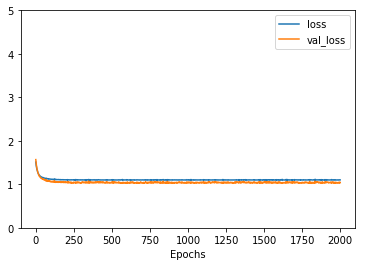

In [42]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
np.mean(hist_p.history['loss'])
plt.ylim(0,5)

In [43]:
model_pm = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_te = model_pm(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(2.0019479, 1.1606661)

Training Set 0.41567588 31
Validation Set 0.23069248 15


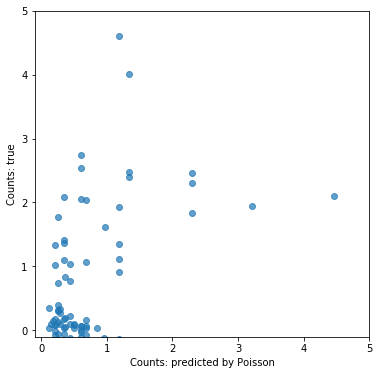

In [44]:
plt.figure(figsize=(6,6))
plt.xlim(-0.1,5)
plt.ylim(-0.1,5)
y_hat_tr = model_pm(X_tr)
plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by Poisson')
plt.ylabel('Counts: true')
plt.savefig('ch05_pois.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

## 3 Using zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [45]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [46]:
## testinging the distribution
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
zero_inf(t).mean()

W0704 14:48:07.878618 139865597429504 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


2.715565   2.7182817   0.7310586 0.9999546    1.0 10.0


<tf.Tensor: id=310897, shape=(5,), dtype=float32, numpy=
array([7.3105848e-01, 7.3105848e-01, 7.3105848e-01, 7.3105848e-01,
       1.2333754e-04], dtype=float32)>

### Definition of the model

In [47]:
## Definition of the model
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
## Definition of the custom parametrized distribution
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
out = Dense(2,  #A
            kernel_regularizer=l2(0.01), #B
            bias_regularizer=l2(0.01))(inputs)#B
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
#B Using a regularisation prevents the network from learning too large weights. Without regularisation, you run into numerical problems.
model_zi.summary()

Tensor("distribution_lambda_2/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_2/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_2/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_2/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_2/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_2/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_2 (Distr ((None,), (None,))        0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
____

### Training of the model (by hand) [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, which we got rid off using regularisation. See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [48]:
optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
loss_values = np.zeros((1000))
for e in range(10):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_tr)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))

0.025004756   0.6247484   0.27135473 0.7500094    -0.98776007 1.0986626
0.08532272   1.1142265   0.09467837 0.61448586    -2.2578049 0.46620792
0.14538766   1.6905261   0.054261714 0.5380224    -2.8581471 0.15238377
0.21434294   2.2604363   0.046183378 0.497875    -3.0278523 -0.00850004
0.28375468   2.740368   0.051534653 0.4827182    -2.9125905 -0.06915477
0.33627015   3.1020303   0.064576805 0.48248586    -2.673143 -0.07008533
0.33518046   3.3501472   0.08308768 0.48957476    -2.4011154 -0.041707024
0.3303233   3.4979155   0.10060602 0.49921462    -2.190509 -0.0031415373
0.3250746   3.5653749   0.11567133 0.5084693    -2.034076 0.033880368
0.3208267   3.5736833   0.13027358 0.5158348    -1.8985419 0.06336038


### Training using keras' build in training

In [49]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik2)
hist_zi = model_zi.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=2000, verbose=False)#, callbacks=[tb]);

(1.0407443450678542, 1.0949766019844864)

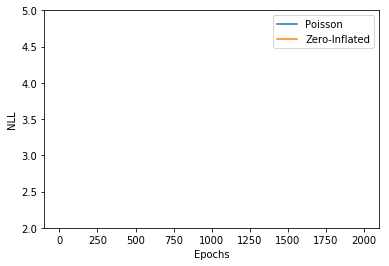

In [50]:
#plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_p.history['val_loss'])
#plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.ylim(2,5)
#plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.legend(['Poisson','Zero-Inflated'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.savefig('ch05_flik.pdf')
np.mean(hist_p.history['val_loss'][1000:]) ,np.mean(hist_zi.history['val_loss'][1000:]) 

In [51]:
model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
y_hat_te = model_zi(X_te)
#mean_absolute_error(y_hat_te, y_te), mean_squared_error(y_hat_te, y_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(1.3811529, 0.7653246)

Training Set 0.41930804 37
Validation Set 0.26694542 20


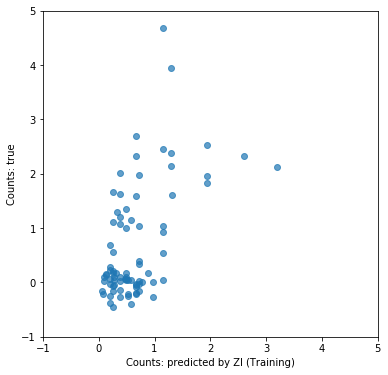

In [52]:
plt.figure(figsize=(6,6))
plt.xlim(-1,5)
plt.ylim(-1,5)
y_hat_tr = model_zi(X_tr)

plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by ZI (Training)')
plt.ylabel('Counts: true')

plt.savefig('ch05_zi.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))